# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регресии
В практических примерах ниже показа

как снижать размерность пространства признаками методами главных компонент (PCR), частных наименьших квадратов (PLS)
как строить логистическую регрессию с регуляризацией параметров (метод ридж и лассо) Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.лиза нализаDA

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# константы
# ядро для генератора случайных чисел
my_seed = 15
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков: 
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [4]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
# из репозитория к книге С.Рашки Python и машинное обучение,
# слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
 C_min_pow=-4, C_max_pow=3.) :
 fig = plt.figure()
 ax = plt.subplot(111) 
 
 # палитра
 colors = sns.color_palette("Spectral", len(col_names)-1)
 
 weights, params = [], []
 for c in np.arange(C_min_pow, C_max_pow+1):
     lr = LogisticRegression(penalty=penalty_name,
         C=10.**c, solver='liblinear',
         multi_class='ovr', random_state=my_seed)
     lr.fit(X, y)
     weights.append(lr.coef_[class_number])
     params.append(10**c)
 weights = np.array(weights)
 for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
     label=col_names[column],
     color=color)
 # отсечки по оптимальным C
 plt.axvline(x=C_opt[class_number], color='magenta',
         linestyle='--', linewidth=1)
 plt.axhline(0, color='black', linestyle='--', linewidth=1)
 plt.xlim([10**(C_min_pow), 10**C_max_pow])
 plt.ylabel('weight coefficient')
 plt.xlabel('C')
 plt.xscale('log')
 plt.legend(loc='upper left')
 ax.legend(loc='upper center',
 bbox_to_anchor=(1.38, 1.03),
 ncol=1, fancybox=True)
 plt.show()

# Загружаем данные:

In [5]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'default_of_credit_card_clients.csv'
DF_all = pd.read_csv(fileURL)
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


# Откладываем 15% наблюдений для прогноза
оставляем только нужные перменные

In [6]:
# наблюдения для моделирования
DF = DF_all.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [7]:
# первые 5 строк фрейма
DF.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
1301,10000,2,3,2,22,0,0,2,0,0,...,8947,9135,8613,2452,7,308,320,328,1000,1
26985,360000,1,1,1,32,-1,-1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
7182,60000,2,2,1,30,2,0,0,0,0,...,58078,59198,60677,3500,3000,1000,2000,2000,1000,1
1906,360000,2,2,1,42,-1,-1,-1,-1,-1,...,1632,22379,8901,6695,1632,1632,22379,8901,4852,0
27856,70000,2,2,2,22,0,0,0,0,0,...,34685,30166,29299,2049,1700,1446,1000,1044,1176,0


In [8]:

# типы столбцов фрейма
DF.dtypes


LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

In [9]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

In [10]:
# оставляем в наборе данных только то, что нужно 
DF = DF[['Y' , 'LIMIT_BAL' , 'SEX' , 'EDUCATION' , 'MARRIAGE' , 'AGE' , 'PAY_0' , 'PAY_2' , 'PAY_3' ,'BILL_AMT1' , 'BILL_AMT2' , 'BILL_AMT3' , 'PAY_AMT1' ,  'PAY_AMT2'  , 'PAY_AMT3']]
DF.head(5)

,Y,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,PAY_AMT1,PAY_AMT2,PAY_AMT3
1301,1,10000,2,3,2,22,0,0,2,10012,9784,9473,2452,7,308
26985,0,360000,1,1,1,32,-1,-1,-2,2500,0,0,0,0,0
7182,1,60000,2,2,1,30,2,0,0,60558,59361,60167,3500,3000,1000
1906,0,360000,2,2,1,42,-1,-1,-1,22237,5683,1632,6695,1632,1632
27856,0,70000,2,2,2,22,0,0,0,66748,52642,40934,2049,1700,1446


# Предварительный анализ данных
Описательные статистики:

Считаем доли классов целевой переменной Y .

In [11]:
# метки классов
DF.Y.unique()

array([1, 0], dtype=int64)

In [12]:
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.779
1    0.221
Name: Y, dtype: float64

Итак, всего целевых классов два, и их доли сильно разняться, с перевесом в пользу класса '0'. Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.

In [13]:
# описательные статистики
DF.describe()

,Y,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,PAY_AMT1,PAY_AMT2,PAY_AMT3
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000
mean,0.221137,167607.137255,1.602588,1.854627,1.549294,35.524471,-0.014510,-0.133176,-0.165922,51195.828314,49147.973490,46796.098549,5621.995294,5.781955e+03,5214.019020
std,0.415021,129517.884174,0.489372,0.790401,0.522187,9.234218,1.126088,1.200379,1.197422,73529.824352,70945.246561,68468.522521,16414.783302,2.027515e+04,17129.286318
min,0.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-157264.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,3476.500000,2975.000000,2643.000000,1000.000000,8.240000e+02,390.000000
50%,0.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,22209.000000,21059.000000,19994.000000,2101.000000,2.007000e+03,1829.000000
75%,0.000000,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,67270.750000,64088.000000,59942.750000,5007.000000,5.000000e+03,4500.000000
max,1.000000,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,746814.000000,743970.000000,693131.000000,873552.000000,1.227082e+06,889043.000000


Выводы по описательным статистикам: значения объясняющих переменных положительные кроме 'PAY_0', 'PAY_2', 'PAY_3' масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.

# Визуализация разброса переменных внутри классов
Поскольку в наборе данных 14 объясняющих переменных, и все они непрерывные (кроме поля 'SEX'), анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.

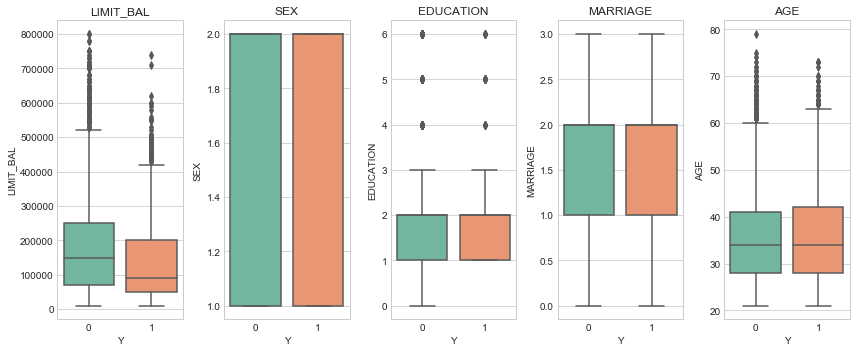

In [14]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[1:6].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()


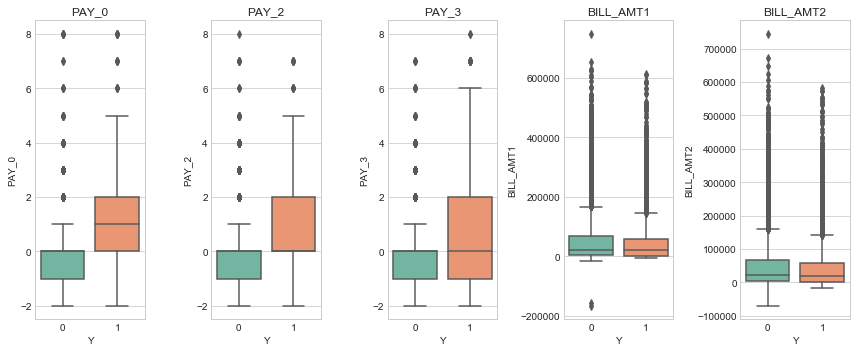

In [15]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[6:11].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

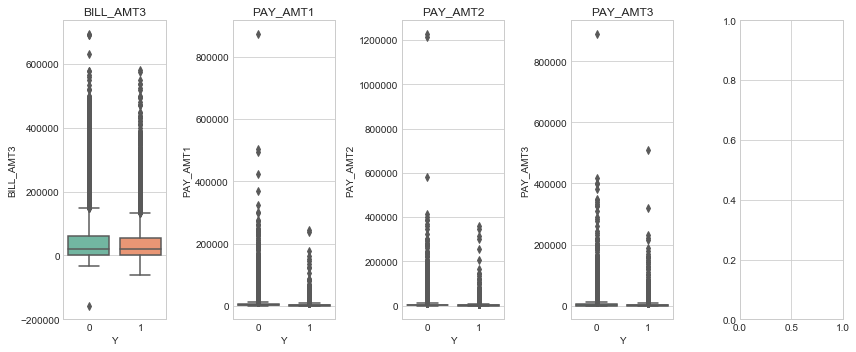

In [16]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
axs = [ax1, ax2, ax3, ax4, ax5]
cols_loop = list(DF.columns[11:15].values)
for col_name in cols_loop :
 i = cols_loop.index(col_name)
 sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
 axs[i].set_ylabel(col_name)
 axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках сходство в медианах и разбросе между классами прослеживается практически по всем объясняющим переменным кроме LIMIT_BAL, PAY_0, PAY_2, PAY_3. Меньше всего различаются коробчатые диаграммы по переменной EDUCATION, MARRIAGE, AGE, BILL_AMT1, BILL_AMT2, BILL_AMT3 . Это говорит о том, классы по зависимой переменной Y неплохо разделяются по всем объясняющим переменным.

# Корреляционный анализ
Теперь посмотрим на взаимодействие объясняющих переменных.

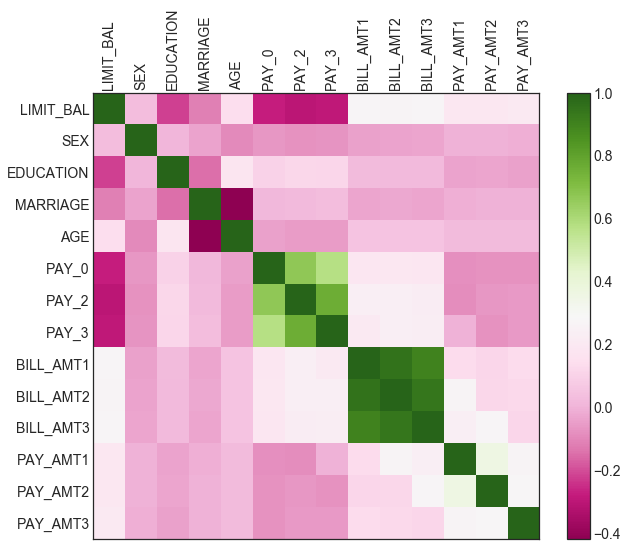

In [17]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns
# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')
# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

In [18]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
# и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
# корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
36,MARRIAGE,AGE,-0.419348,0.0
5,LIMIT_BAL,PAY_2,-0.297755,0.0
6,LIMIT_BAL,PAY_3,-0.287680,0.0
4,LIMIT_BAL,PAY_0,-0.271776,0.0
1,LIMIT_BAL,EDUCATION,-0.217254,0.0
25,EDUCATION,MARRIAGE,-0.144784,0.0
2,LIMIT_BAL,MARRIAGE,-0.111787,0.0
15,SEX,AGE,-0.086697,0.0
67,PAY_2,PAY_AMT1,-0.083586,0.0
60,PAY_0,PAY_AMT1,-0.080992,0.0


# Методы снижения резмерности
Посмотрим, как работают методы снижения размерности:

регрессия на главные компоненты (PCR) (Мой вариант)

частный метод наименьших квадратов (PLS) 

Оба метода требуют предварительной стандартизации переменных.

In [19]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :15].values)
# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
 print('Столбец ', i_col, ': среднее = ',
 np.round(np.mean(X_train_std[:, i_col]), 2),
 ' Станд. отклонение = ',
 np.round(np.std(X_train_std[:, i_col]), 2), sep='')


Столбец 0: среднее = 0.0 Станд. отклонение = 1.0
Столбец 1: среднее = 0.0 Станд. отклонение = 1.0
Столбец 2: среднее = -0.0 Станд. отклонение = 1.0
Столбец 3: среднее = -0.0 Станд. отклонение = 1.0
Столбец 4: среднее = -0.0 Станд. отклонение = 1.0
Столбец 5: среднее = -0.0 Станд. отклонение = 1.0
Столбец 6: среднее = -0.0 Станд. отклонение = 1.0
Столбец 7: среднее = -0.0 Станд. отклонение = 1.0
Столбец 8: среднее = -0.0 Станд. отклонение = 1.0
Столбец 9: среднее = -0.0 Станд. отклонение = 1.0
Столбец 10: среднее = 0.0 Станд. отклонение = 1.0
Столбец 11: среднее = -0.0 Станд. отклонение = 1.0
Столбец 12: среднее = -0.0 Станд. отклонение = 1.0
Столбец 13: среднее = 0.0 Станд. отклонение = 1.0
Столбец 14: среднее = 0.0 Станд. отклонение = 1.0


C:\Users\Admin\anaconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\anaconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Регрессия на главные компоненты (PCR)
Пересчитаем объясняющие показатели в главные компоненты.

In [20]:
# функция с методом главных компонент
pca = PCA()
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF[['Y']].astype(str))
Y_train = np.ravel(Y_train)
Y_train = Y_train[:25500]
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)
# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PCR:\n',
 np.around(frac_var_expl, 3),
 '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))


Доли объяснённой дисперсии по компонентам в PCR:
 [0.228 0.182 0.102 0.086 0.069 0.065 0.053 0.051 0.044 0.038 0.035 0.028
 0.014 0.005 0.002] 
Общая сумма долей: 1.0


In [21]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
1,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
2,0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0
3,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
4,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0
5,-0.0,-0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
6,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
7,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
8,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0.0,-0.0
9,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0


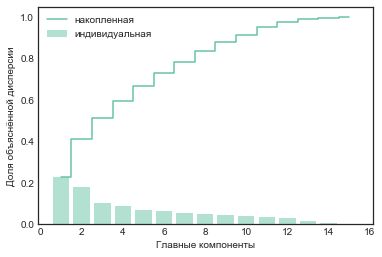

In [22]:
n_components = len(pca.explained_variance_ratio_)
plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='индивидуальная')
plt.step(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

Столбцы на графике показывают долю исходной дисперсии исходных переменных, которую
объясняет главная компонента. Линией показана накопленная доля. Так, видно, что первые 6
компонент объясняют 80% исходной дисперсии .


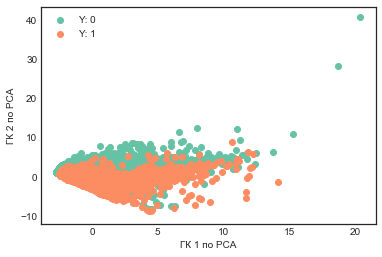

In [23]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
# график классов в пространстве ГК
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0],
 X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0],
 X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')
plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()
plt.show()

Видно, что в координатах двух компонент, рассчитанных методом PCR, классы плохо разделимы. Теперь оценим точность модели с перекрёстной проверкой.

In [24]:
# функция оценки логистической регрессии
logit = LogisticRegression(penalty='l2', solver='lbfgs')
# функция разбиения на блоки для перекрёстной проверки
kf_14 = KFold(n_splits=14, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_14,
 scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 14 блокам',
 '\nAcc = ', np.around(score[0], 2), sep='')


Модель logit_PC2, перекрёстная проверка по 14 блокам
Acc = 0.83


# Методы сжатия
Ридж-регрессия

Функция LogisticRegression() умеет работать с мультиклассовой классификацией,
используя при оценке параметров подход один класс против остальных. Построим ридж на
наших данных.

In [25]:
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='lbfgs')
# оцениваем параметры
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
 '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [0.] 
Коэффициенты моделей для классов:
 [[-0.01  -0.001 -0.01   0.005 -0.012 -0.003  0.01  -0.011 -0.012 -0.028
   0.041 -0.015  0.02   0.001 -0.023]]


Подбираем гиперпараметр регуляризации с помощью перекрёстной проверки. В функции
LogisticRegression() есть аргумент – это инверсия гиперпараметра .


In [26]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2,
 penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
# точность для каждого класса
ridge_cv.C_

array([0.0001])

In [27]:
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
 '\nAcc = ', score[1], sep='')


Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.505


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на
уровне оптимального параметра .


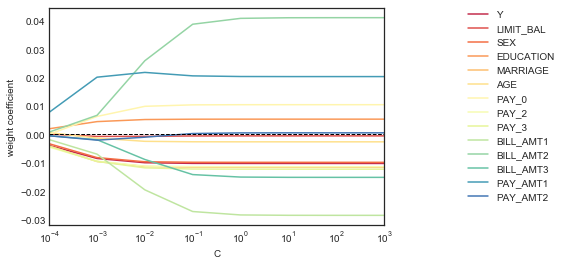

In [28]:
# график динамики коэффициентов в ридж-регрессии 
# модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.

In [29]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Acc,Модель
0,0.829,logit_PC2
1,0.505,logit_ridge


Все модели показывают высокую точность по показателю , при этом самой точной оказывается logit_PC2. Сделаем прогноз на отложенные наблюдения.

In [34]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :15].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.78      0.47      0.58      3503
           1       0.22      0.53      0.31       997

   micro avg       0.48      0.48      0.48      4500
   macro avg       0.50      0.50      0.45      4500
weighted avg       0.65      0.48      0.52      4500



C:\Users\Admin\anaconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\anaconda3\envs\env1\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
